In [ ]:
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine, text

from rs_graph.db import models as db_models

# Create a connection to the database
engine = create_engine("sqlite:///rs_graph/data/files/rs-graph-v1-prod.db")

# Helper function to make this easy


def read_table(table: str) -> pd.DataFrame:
    return pd.read_sql(text(f"SELECT * FROM {table}"), engine)


# Load all author developer links, authors, and devs
researcher_dev_links = read_table(
    db_models.ResearcherDeveloperAccountLink.__tablename__
)
researchers = read_table(db_models.Researcher.__tablename__)
devs = read_table(db_models.DeveloperAccount.__tablename__)

In [2]:
reduced_dev_links = (
    researcher_dev_links.sort_values(
        by="predictive_model_confidence",
        ascending=False,
    )
    .drop_duplicates(
        subset=["developer_account_id"],
        keep="first",
    )
    .drop_duplicates(
        subset=["researcher_id"],
        keep="first",
    )
    .copy()
)

# Select columns of interest, change column names, and merge
merged = (
    reduced_dev_links[
        [
            "researcher_id",
            "developer_account_id",
            "predictive_model_confidence",
        ]
    ]
    .rename(
        columns={
            "predictive_model_confidence": "confidence",
        },
    )
    .merge(
        researchers[["id", "name"]].rename(
            columns={
                "id": "researcher_id",
                "name": "researcher_name",
            },
        ),
        on="researcher_id",
    )
    .merge(
        devs[["id", "username", "name"]].rename(
            columns={
                "id": "developer_account_id",
                "username": "dev_username",
                "name": "dev_provided_name",
            },
        ),
        on="developer_account_id",
    )
)
final_set = (
    merged.drop(
        columns=[
            "researcher_id",
            "developer_account_id",
        ],
    )[
        [
            "researcher_name",
            "dev_username",
            "dev_provided_name",
            "confidence",
        ]
    ]
    .loc[merged["confidence"] >= 0.97]
    .sort_values(by="confidence")
    .reset_index(drop=True)
)

final_set.sample(10, random_state=42)

,researcher_name,dev_username,dev_provided_name,confidence
29058,Rosana Montes,rosanamontes,Rosana Montes,0.984611
68484,Antón Filatov,art32fil,Artyom Filatov,0.985101
53760,Krishna Sri Ipsit Mantri,ipsitmantri,Ipsit Mantri,0.984943
66014,Heiko Hoppe,HeikoFHH,Heiko Hoppe,0.985074
8764,Florin Gogianu,floringogianu,Florin Gogianu,0.983929
55937,Mehmet Saygın Seyfioğlu,aldraus,Saygin,0.984967
88596,Junyi Lu,Junyi-L,JL,0.985411
52891,Yichao Gao,Einholz-Gao,Yichao Gao,0.984933
69261,Nicole Han,nicole7han,Nicole Han,0.985109
85642,Nicholas Horne,nicholashorne1,None,0.985342


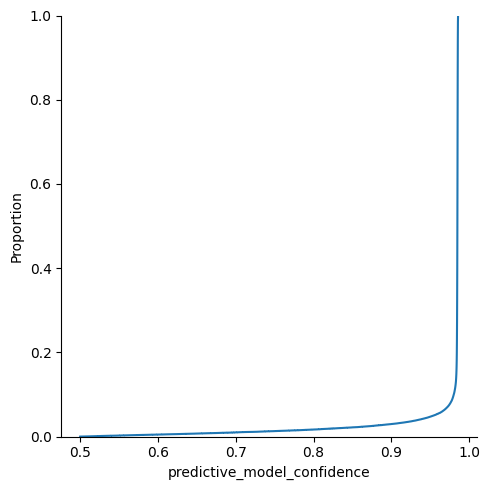

In [ ]:
# Plot the distribution of confidence values in this final set
sns.displot(researcher_dev_links, x="predictive_model_confidence", kind="ecdf")

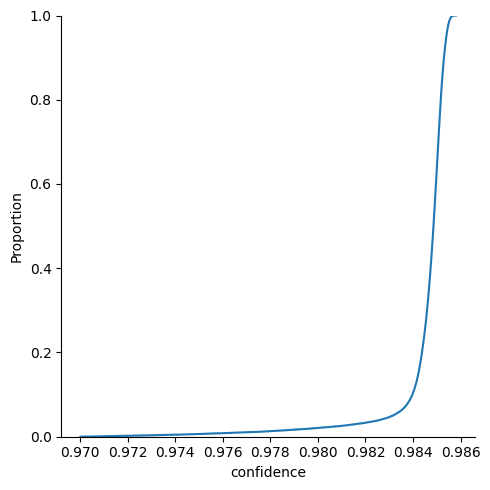

In [4]:
sns.displot(final_set, x="confidence", kind="ecdf")